In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
# %matplotlib widget

root_dir = "C:\\Users\\Lenovo\\Desktop\\assemblyhelper"

In [2]:
# Load RGB and PCD raw datas
data_path = "assets/exp_data/raw_datas/part_space1.npy"
img_info = np.load(os.path.join(root_dir, data_path), allow_pickle=True)
color_data = img_info[()]['color']
point_data = img_info[()]['pointcloud']

In [3]:
# Visualize depth and RGB map
depth_map = cv2.normalize(point_data[:, :, 2], None, 0, 255, cv2.NORM_MINMAX)
depth_map = depth_map.astype(np.uint8)
depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2RGB)
color_map = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
# color_map = color_data

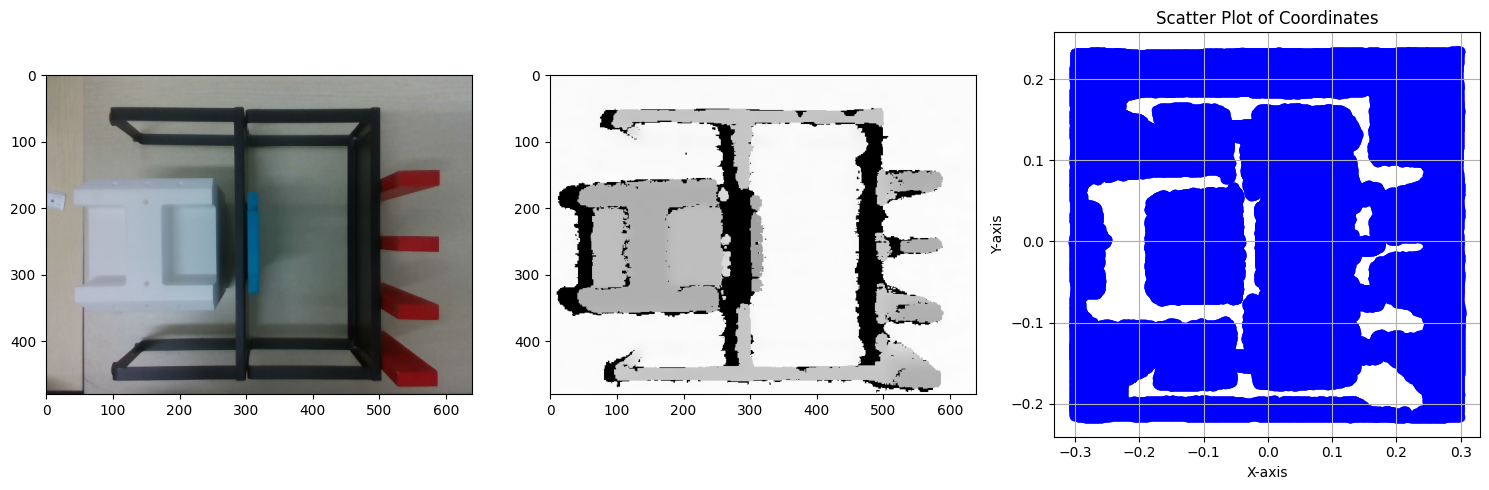

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()
ax[0].imshow(color_map)
ax[1].imshow(depth_map)

# visualize xy coordinate
xy_data = point_data[..., :2].reshape((-1,2))
ax[2].scatter(xy_data[:, 0], -xy_data[:, 1], marker='o', color='blue')
ax[2].set_title('Scatter Plot of Coordinates')
ax[2].set_xlabel('X-axis')
ax[2].set_ylabel('Y-axis')
ax[2].grid(True)

plt.tight_layout()
plt.show()

In [5]:
# Load mask data
mask_path = "assets/exp_data/masks/part_space1.npy"
mask_info = np.load(os.path.join(root_dir, mask_path), allow_pickle=True)

In [6]:
# Extract mask region
obj_mask = mask_info[()]['battery']
projected_data = point_data[:, :, :2]
depth_data =  point_data[:, :, 2]

# filter by specific objs mask
masked_proj_cloud = projected_data[obj_mask != 0]
masked_depth = depth_data[obj_mask != 0]
# filter zero points
fliter_data = masked_proj_cloud[masked_depth != 0]
filter_depth = masked_depth[masked_depth != 0]
# print(filter_depth.shape)
# print(fliter_data.shape)
# filter outlier data
min_depth = np.min(filter_depth)
threshold = min_depth + 0.05
indices = np.where(filter_depth < threshold)[0]
fliter_data = fliter_data[indices]
filter_depth = filter_depth[indices]

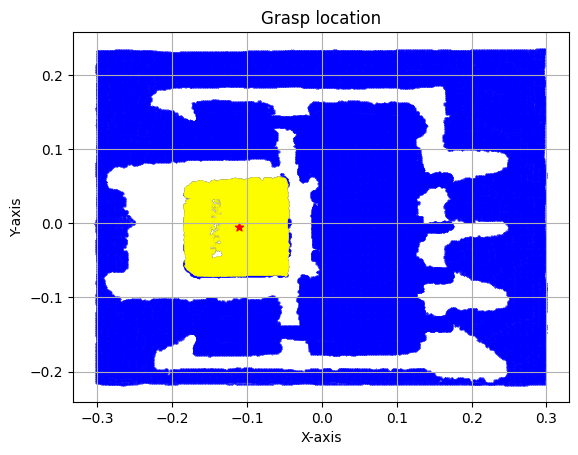

In [7]:
# Get raw data & grasp center in point in PCD
# %matplotlib ipympl
xy_data = point_data[..., :2].reshape((-1,2))
plt.scatter(xy_data[:, 0], -xy_data[:, 1], marker='o', color='blue', s=0.1)

mean_xy = np.mean(fliter_data, axis=0)
plt.scatter(fliter_data[:, 0], -fliter_data[:, 1], marker='o', color='yellow', s=0.1)
plt.scatter(mean_xy[0], -mean_xy[1], marker='*', color='red')

plt.title('Grasp location')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()
# grasp_save_path = "assets/exp_data/results/grasp_part1_3.jpg"
# plt.savefig(os.path.join(root_dir, grasp_save_path))

In [8]:
# Visualize grasp center in raw image
matching_indices = [0, 0]
min_distance = 1e10
for i in range(projected_data.shape[0]):
    for j in range(projected_data.shape[1]):
        # select center point only in masked region
        if obj_mask[i][j] == False:
            continue
        if depth_data[i][j]-min_depth > 0.05:
            continue
        distance = np.linalg.norm(projected_data[i, j] - mean_xy)
        if distance < min_distance:
            min_distance = distance
            matching_indices = np.array([j, i])
            
# cv2.circle(color_map, matching_indices, radius=5, color=[0,0,255], thickness=-1)
# plt.imshow(color_map)

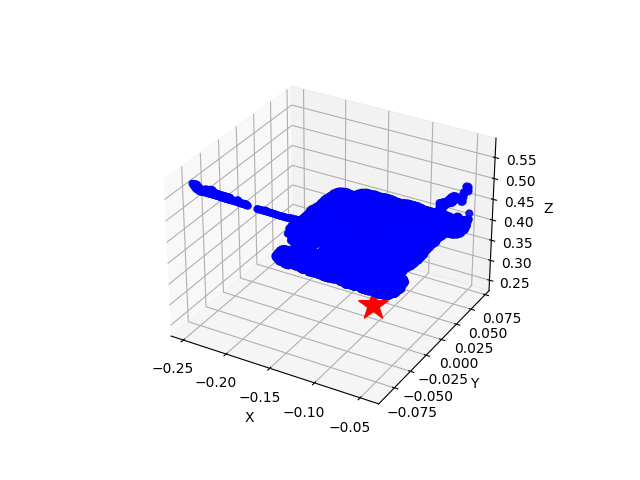

In [11]:
# Visualize object's PCD
# %matplotlib inline
%matplotlib ipympl
# %matplotlib notebook
# %matplotlib widget 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# filter pcd by zero & mask region
processed_data = copy.deepcopy(point_data[obj_mask != 0])
processed_data = processed_data[~np.any(processed_data == 0, axis=1)]
ax.scatter(processed_data[:, 0], processed_data[:, 1], processed_data[:, 2], c='b', marker='o', label='pcd')

# filter pcd by min_depth
surface_data = processed_data[indices]
ax.scatter(surface_data[:, 0], surface_data[:, 1], surface_data[:, 2], c='y', marker='o', label='pcd')


grasp_center = point_data[matching_indices[1], matching_indices[0]]
ax.scatter(grasp_center[0], grasp_center[1], grasp_center[2]-0.15, c='r', marker='*', s=500, label='grasp')

# ax.scatter(point_data[..., 0], -point_data[..., 1], point_data[..., 2], c='b', marker='o', label='grasp')


# set [X,Y,Z] axis on figure
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # hide x-axis' number
# ax.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False)  # hide y-axis' number
ax.tick_params(axis='z', which='both', bottom=False, top=False, labelbottom=False)   # hide z-axis' number

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])

ax.grid(True)

# visualize figure
plt.show()

In [41]:
def visualize_grasp(center):
    bbox = np.array([[-50, 25], [50, 25], [-50, -25], [50, -25]])
    top_left = center + bbox[0]
    top_right = center + bbox[1]
    bottom_left = center + bbox[2]
    bottom_right = center + bbox[3]
    width_color = (13, 18, 130)
    height_color = (255, 108, 34)
    cv2.line(color_map, top_left, top_right, width_color,2)
    cv2.line(color_map, bottom_left, bottom_right, width_color,2)
    cv2.line(color_map, top_left, bottom_left, height_color,3)
    cv2.line(color_map, top_right, bottom_right, height_color,3)

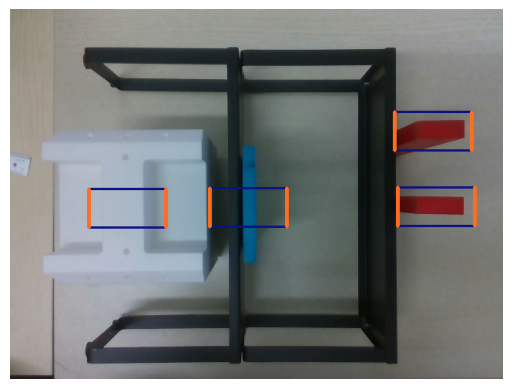

In [42]:
# Visualize grasp pose in raw image
visualize_grasp(matching_indices)
plt.axis('off')
plt.imshow(color_map)
# grasp_save_path = "assets/exp_data/results/grasp_part2.jpg"
# plt.savefig(os.path.join(root_dir, grasp_save_path), bbox_inches='tight', pad_inches=0)

In [43]:
grasp_save_path = "assets/exp_data/results/grasp_part3_1.jpg"
cv2.imwrite(os.path.join(root_dir, grasp_save_path), cv2.cvtColor(color_map, cv2.COLOR_RGB2BGR))

True